# Purchase History ML model

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load the dataset

In [3]:
file_path = '/Users/derrickmarkbavaudbaruga/Documents/fall 2024/Extra Xtra/talkn bout practice/magsafe/ml models/2 Purchase History/Sales Data.csv'
data = pd.read_csv(file_path)

### Display the first few rows of the dataframe

In [3]:
print("Initial Data Preview:")
print(data.head())

Initial Data Preview:
   Unnamed: 0  Order ID       Product Category               Product  \
0           0    295665  Laptops and Computers    Macbook Pro Laptop   
1           1    295666        Home Appliances    LG Washing Machine   
2           2    295667        Charging Cables  USB-C Charging Cable   
3           3    295668               Monitors      27in FHD Monitor   
4           4    295669        Charging Cables  USB-C Charging Cable   

   Quantity Ordered  Price Each        Order Date  \
0                 1     1700.00  30-12-2019 00:01   
1                 1      600.00  29-12-2019 07:03   
2                 1       11.95  12-12-2019 18:21   
3                 1      149.99  22-12-2019 15:13   
4                 1       11.95  18-12-2019 12:38   

                         Purchase Address  Month    Sales            City  \
0  136 Church St, New York City, NY 10001     12  1700.00   New York City   
1     562 2nd St, New York City, NY 10001     12   600.00   New York Cit

### Summary Statistics

In [4]:
summary = data.describe()
print(summary)

          Unnamed: 0       Order ID  Quantity Ordered     Price Each  \
count  185950.000000  185950.000000     185950.000000  185950.000000   
mean     8340.388475  230417.569379          1.124383     184.399735   
std      5450.554093   51512.737110          0.442793     332.731330   
min         0.000000  141234.000000          1.000000       2.990000   
25%      3894.000000  185831.250000          1.000000      11.950000   
50%      7786.000000  230367.500000          1.000000      14.950000   
75%     11872.000000  275035.750000          1.000000     150.000000   
max     25116.000000  319670.000000          9.000000    1700.000000   

               Month          Sales           Hour  
count  185950.000000  185950.000000  185950.000000  
mean        7.059140     185.490917      14.413305  
std         3.502996     332.919771       5.423416  
min         1.000000       2.990000       0.000000  
25%         4.000000      11.950000      11.000000  
50%         7.000000      14.9500

In [5]:
summary = data.describe(include = 'all')
print(summary)

           Unnamed: 0       Order ID Product Category               Product  \
count   185950.000000  185950.000000           185950                185950   
unique            NaN            NaN                8                    19   
top               NaN            NaN    Audio Devices  USB-C Charging Cable   
freq              NaN            NaN            47756                 21903   
mean      8340.388475  230417.569379              NaN                   NaN   
std       5450.554093   51512.737110              NaN                   NaN   
min          0.000000  141234.000000              NaN                   NaN   
25%       3894.000000  185831.250000              NaN                   NaN   
50%       7786.000000  230367.500000              NaN                   NaN   
75%      11872.000000  275035.750000              NaN                   NaN   
max      25116.000000  319670.000000              NaN                   NaN   

        Quantity Ordered     Price Each        Orde

## Visualisation

### Barplot of the Quantity Ordered by Product Category

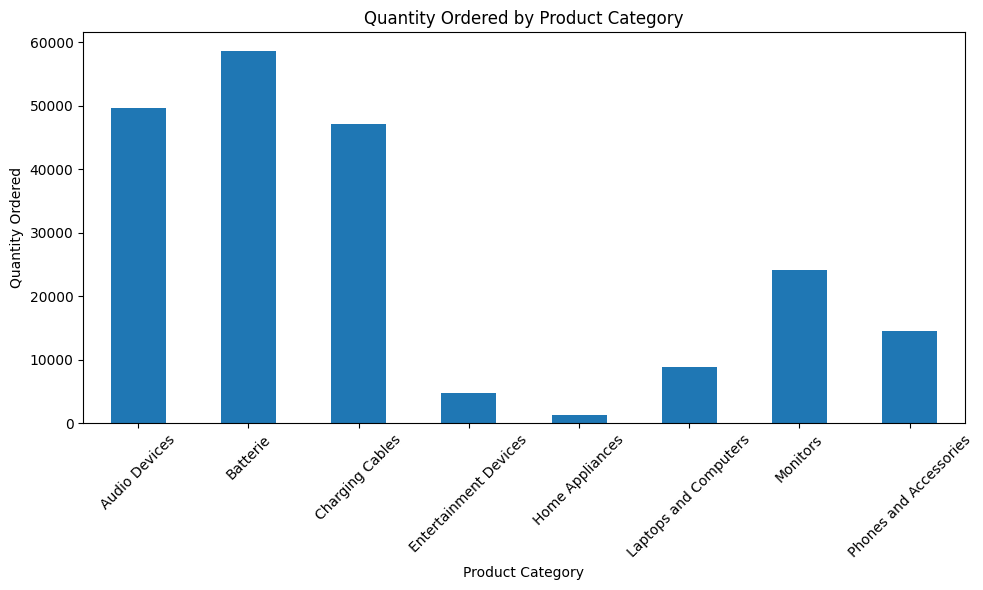

In [7]:
%matplotlib inline

plt.figure(figsize=(10,6))
data.groupby('Product Category')['Quantity Ordered'].sum().plot(kind='bar')
plt.title('Quantity Ordered by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Quantity Ordered')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()       # Adjust layout to fit labels
plt.show()

### Line graph of sales per month

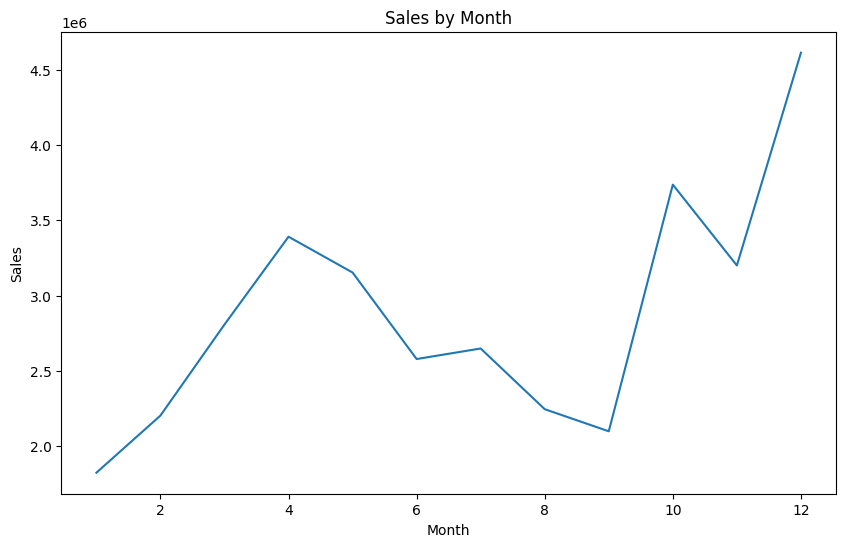

In [8]:
plt.figure(figsize=(10,6))
data.groupby('Month')['Sales'].sum().plot(kind='line')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

### Bar graph of the sales by city

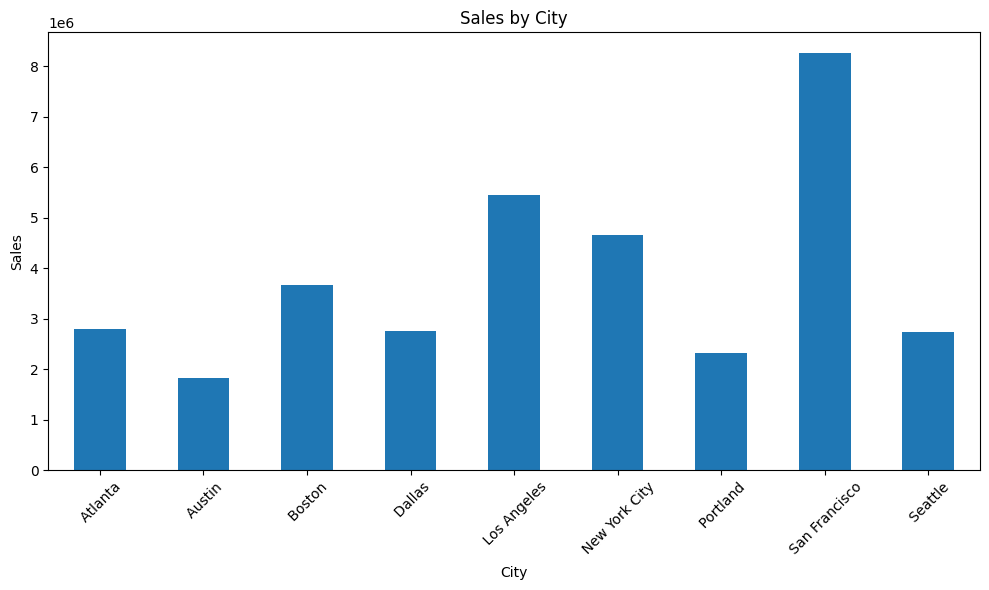

In [9]:
%matplotlib inline

plt.figure(figsize=(10,6))
data.groupby('City')['Sales'].sum().plot(kind='bar')
plt.title('Sales by City')
plt.xlabel('City')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()       # Adjust layout to fit labels
plt.show()

### Bar graph of sales by time of day

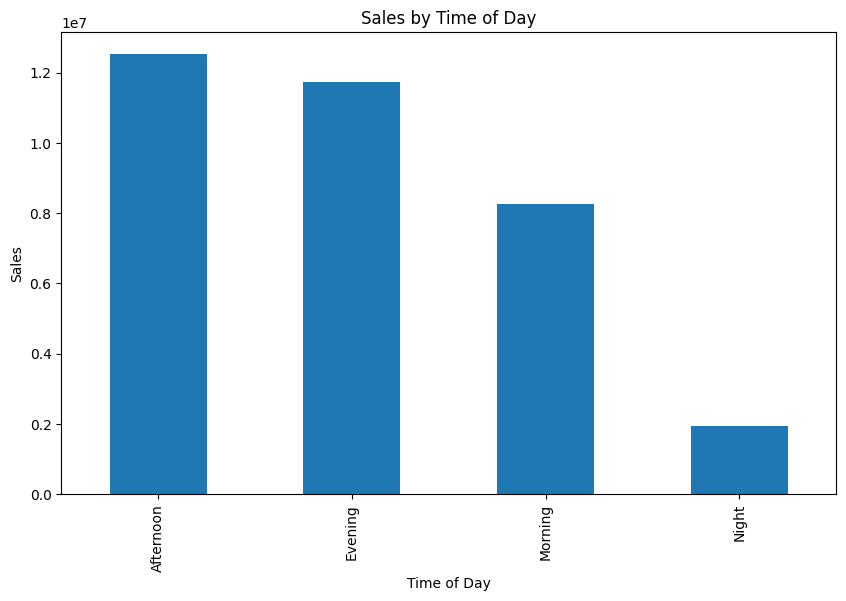

In [10]:
plt.figure(figsize=(10,6))
data.groupby('Time of Day')['Sales'].sum().plot(kind='bar')
plt.title('Sales by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Sales')
plt.show()

## Data Cleaning

In [4]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [5]:
# Convert 'Order Date' to datetime and extract features
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y %H:%M')
data['Order Year'] = data['Order Date'].dt.year
data['Order Month'] = data['Order Date'].dt.month
data['Order Day'] = data['Order Date'].dt.day
data['Order Hour'] = data['Order Date'].dt.hour

In [6]:
# Drop unnecessary columns
data.drop(['Unnamed: 0', 'Order ID', 'Purchase Address', 'Order Date', 'City', 'Time of Day'], axis=1, inplace=True)

In [7]:
# Convert categorical columns to dummy variables
data = pd.get_dummies(data, columns=['Product Category', 'Product'])

## Feature Engineering

### Separate features and target

In [8]:
# Separate features and target
X = data.drop('Sales', axis=1).values
y = data['Sales'].values

### Split the data into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize the features

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Convert to PyTorch tensors

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Create DataLoader instances for training and testing

In [12]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SalesPredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Initialize the model

In [13]:
input_dim = X_train.shape[1]
model = SalesPredictionModel(input_dim)

### Define loss function and optimizer

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)
        
        epoch_loss = total_loss / len(train_loader.dataset)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_X.size(0)
    
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

### Train the model

In [16]:
train_model(model, criterion, optimizer, train_loader, num_epochs=200)

Epoch [10/200], Loss: 1.1846
Epoch [20/200], Loss: 1.2949
Epoch [30/200], Loss: 1.0770
Epoch [40/200], Loss: 0.7873
Epoch [50/200], Loss: 1.1039
Epoch [60/200], Loss: 1.3503
Epoch [70/200], Loss: 1.3997
Epoch [80/200], Loss: 1.1370
Epoch [90/200], Loss: 1.0620
Epoch [100/200], Loss: 0.9857
Epoch [110/200], Loss: 0.7715
Epoch [120/200], Loss: 0.6564
Epoch [130/200], Loss: 1.1027
Epoch [140/200], Loss: 0.7548
Epoch [150/200], Loss: 1.1009
Epoch [160/200], Loss: 0.9684
Epoch [170/200], Loss: 0.7167
Epoch [180/200], Loss: 0.9327
Epoch [190/200], Loss: 0.9720
Epoch [200/200], Loss: 1.5229


### Evaluate the model

In [17]:
test_loss = evaluate_model(model, criterion, test_loader)
print(f'Mean Squared Error on Test Set: {test_loss:.4f}')

Mean Squared Error on Test Set: 0.7493
